In [ ]:
import sys
import pandas as pd 
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import IPython
import sklearn 
import xgboost as xgb

In [166]:
from sklearn.model_selection import train_test_split
X = pd.read_csv("../data/preprocessed/training.data.csv")
y = pd.read_csv("../data/preprocessed/target_data.csv")
X = X.loc[:, ~X.columns.str.contains("^Unnamed")]
y = y["yield_kg_per_hectare"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [169]:
X.head(8)

,soil_moisture_%,soil_pH,temperature_C,rainfall_mm,humidity_%,sunlight_hours,pesticide_usage_ml,latitude,longitude,region_le,croptype_le,cropdisease_le,irrigation_type_le,fertilizer_type_le,sowing_month,sowing_season,temp_humidity_index,soil_pH_squared,temperature_squared,region_croptype,fert_irrigation,lat_lon_ratio,lat_lon_sum,geo_cluster,log_rainfall,log_pesticide,has_disease,disease_humidity,disease_temperature,disease_fertilizer
0,35.95,5.99,17.79,75.62,77.03,7.27,6.34,14.970941,82.997689,2,4,0,2,2,1,1,1370.3637,35.8801,316.4841,8,4,0.180378,97.968630,0,4.338858,1.993339,0,0.00,0.00,0
1,19.74,7.24,30.18,89.91,61.13,5.67,9.60,16.613022,70.869009,4,3,2,3,0,2,1,1844.9034,52.4176,910.8324,12,0,0.234419,87.482031,0,4.509870,2.360854,1,122.26,60.36,0
2,29.32,7.16,27.37,265.43,68.87,8.23,15.26,19.503156,79.068206,4,4,0,0,1,2,1,1884.9719,51.2656,749.1169,16,0,0.246662,98.571362,0,5.585112,2.788708,0,0.00,0.00,0
3,17.33,6.03,33.73,212.01,70.46,5.03,25.80,31.071298,85.519998,0,1,2,3,2,2,1,2376.6158,36.3609,1137.7129,0,6,0.363322,116.591296,2,5.361339,3.288402,1,140.92,67.46,4
4,19.37,5.92,33.86,269.09,55.73,7.93,25.65,16.568540,81.691720,0,0,3,2,1,2,1,1887.0178,35.0464,1146.4996,0,2,0.202818,98.260260,0,5.598755,3.282789,1,167.19,101.58,3
5,44.91,5.78,24.87,238.95,83.06,4.92,24.00,23.227859,89.421568,0,2,2,3,1,1,1,2065.7022,33.4084,618.5169,0,3,0.259757,112.649427,2,5.480431,3.218876,1,166.12,49.74,2
6,36.28,7.04,21.80,123.38,47.91,4.02,39.29,25.224255,73.056785,2,3,2,1,1,3,2,1044.4380,49.5616,475.2400,6,1,0.345269,98.281040,1,4.823341,3.696103,1,95.82,43.60,2
7,27.10,5.72,22.26,296.33,80.34,5.44,47.61,23.317654,72.515210,1,1,0,3,1,1,1,1788.3684,32.7184,495.5076,1,3,0.321555,95.832864,1,5.694843,3.883829,0,0.00,0.00,0


In [170]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

param_grid = {
    "n_estimators": [200, 500, 1000],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    # допустимые значения:
    "max_features": ["sqrt", "log2", 0.8, None],  # 0.8 = 80% фич, None = все фичи
}

rf = RandomForestRegressor(random_state=42, n_jobs=-1, bootstrap=True)

grid = GridSearchCV(
    rf, param_grid,
    cv=5,
    scoring="r2",         # можно попробовать 'neg_mean_absolute_error'
    verbose=2,
    n_jobs=-1,
    error_score="raise"   # так ты увидишь точную ошибку, если что-то сломается
)
grid.fit(X_train, y_train)

print("Лучшие параметры:", grid.best_params_)
print("Лучший R² (CV):", grid.best_score_)


Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Лучшие параметры: {'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Лучший R² (CV): -0.018856873548322283


In [184]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

best_rf = grid.best_estimator_

y_pred = best_rf.predict(X_test)
mae  = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2   = r2_score(y_test, y_pred)

print(f"MAE : {mae:.2f} кг/га")
print(f"RMSE: {rmse:.2f} кг/га")
print(f"R²  : {r2:.3f}")


MAE : 1061.21 кг/га
RMSE: 1202.31 кг/га
R²  : -0.047


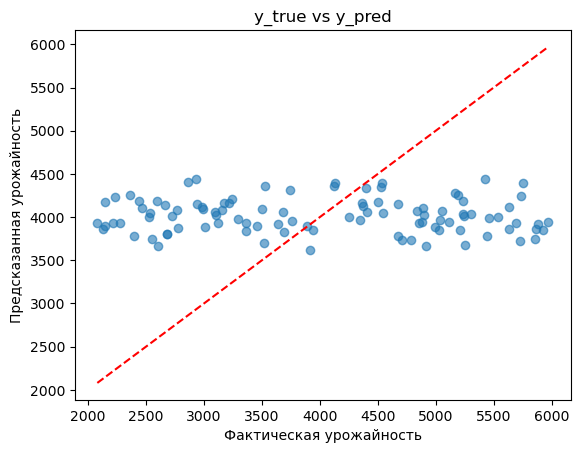

In [173]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred, alpha=0.6)
plt.xlabel("Фактическая урожайность")
plt.ylabel("Предсказанная урожайность")
plt.title("y_true vs y_pred")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")  # линия идеала
plt.show()


In [175]:
import numpy as np
import pandas as pd

print("y_pred shape:", np.asarray(y_pred).shape)
print("y_test shape:", np.asarray(y_test).shape)

y_pred_1d = np.asarray(y_pred).ravel()     
y_test_1d = np.asarray(getattr(y_test, "values", y_test)).ravel()

results = pd.DataFrame({
    "Факт": y_test_1d,
    "Прогноз": y_pred_1d
})

results["Ошибка"] = results["Факт"] - results["Прогноз"]
results["Абс_ошибка"] = results["Ошибка"].abs()

print(results)


y_pred shape: (100,)
y_test shape: (100,)
       Факт      Прогноз       Ошибка   Абс_ошибка
0   5867.22  3867.202391  2000.017609  2000.017609
1   5252.74  3680.285528  1572.454472  1572.454472
2   5192.59  4252.345546   940.244454   940.244454
3   2980.51  4122.365878 -1141.855878  1141.855878
4   5235.26  4184.598541  1050.661459  1050.661459
..      ...          ...          ...          ...
95  5025.21  3853.165169  1172.044831  1172.044831
96  2858.28  4409.502089 -1551.222089  1551.222089
97  5878.35  3921.976746  1956.373254  1956.373254
98  3293.47  3978.327615  -684.857615   684.857615
99  5755.72  4393.539069  1362.180931  1362.180931

[100 rows x 4 columns]


In [176]:
y_test

361    5867.22
73     5252.74
374    5192.59
155    2980.51
104    5235.26
        ...   
347    5025.21
86     2858.28
75     5878.35
438    3293.47
15     5755.72
Name: yield_kg_per_hectare, Length: 100, dtype: float64

In [177]:
X_train.head()

,soil_moisture_%,soil_pH,temperature_C,rainfall_mm,humidity_%,sunlight_hours,pesticide_usage_ml,latitude,longitude,region_le,croptype_le,cropdisease_le,irrigation_type_le,fertilizer_type_le,sowing_month,sowing_season,temp_humidity_index,soil_pH_squared,temperature_squared,region_croptype,fert_irrigation,lat_lon_ratio,lat_lon_sum,geo_cluster,log_rainfall,log_pesticide,has_disease,disease_humidity,disease_temperature,disease_fertilizer
249,26.46,5.88,31.83,254.31,81.41,4.73,39.71,21.520866,85.419919,2,3,0,3,0,2,1,2591.2803,34.5744,1013.1489,6,0,0.251942,106.940785,0,5.542478,3.706474,0,0.00,0.00,0
433,38.82,7.20,23.30,94.89,70.89,6.59,13.25,15.992381,87.410792,4,3,1,2,1,3,2,1651.7370,51.8400,542.8900,12,2,0.182957,103.403173,0,4.563202,2.656757,1,70.89,23.30,1
19,16.99,7.34,21.99,255.13,83.57,5.34,19.77,19.991960,89.622994,4,2,2,3,0,1,1,1837.7043,53.8756,483.5601,8,0,0.223067,109.614954,0,5.545685,3.033510,1,167.14,43.98,0
322,25.20,5.94,33.55,286.56,85.69,9.39,6.80,23.278043,79.585387,3,1,2,2,2,2,1,2874.8995,35.2836,1125.6025,3,4,0.292491,102.863430,1,5.661432,2.054124,1,171.38,67.10,4
332,41.36,7.44,30.08,298.52,73.34,8.80,36.01,12.921902,70.495912,0,0,0,2,0,3,2,2206.0672,55.3536,904.8064,0,0,0.183300,83.417814,0,5.702181,3.611188,0,0.00,0.00,0


In [178]:
bias = (y_pred - y_test).mean()
print("Средний сдвиг прогноза:", bias)


Средний сдвиг прогноза: 6.584192459186069


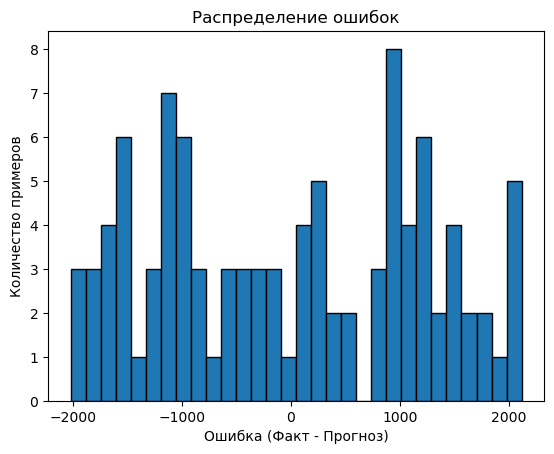

In [179]:
import matplotlib.pyplot as plt

plt.hist(y_test - y_pred, bins=30, edgecolor="black")
plt.title("Распределение ошибок")
plt.xlabel("Ошибка (Факт - Прогноз)")
plt.ylabel("Количество примеров")
plt.show()


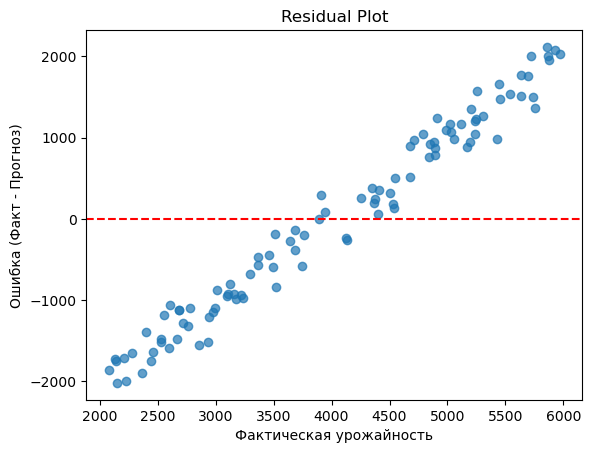

In [180]:
plt.scatter(y_test, y_test - y_pred, alpha=0.7)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Фактическая урожайность")
plt.ylabel("Ошибка (Факт - Прогноз)")
plt.title("Residual Plot")
plt.show()


In [181]:
fi = pd.DataFrame({"Feature": X_train.columns, "Importance": best_rf.feature_importances_})
print(fi.sort_values("Importance", ascending=False))


                Feature  Importance
25        log_pesticide    0.062372
0       soil_moisture_%    0.062276
8             longitude    0.057758
5        sunlight_hours    0.051796
3           rainfall_mm    0.051397
4            humidity_%    0.050271
22          lat_lon_sum    0.050161
6    pesticide_usage_ml    0.049942
18  temperature_squared    0.049285
16  temp_humidity_index    0.047564
2         temperature_C    0.047062
24         log_rainfall    0.044077
27     disease_humidity    0.040058
7              latitude    0.039996
17      soil_pH_squared    0.039715
1               soil_pH    0.038147
28  disease_temperature    0.034892
21        lat_lon_ratio    0.034442
19      region_croptype    0.024655
10          croptype_le    0.018296
9             region_le    0.017409
29   disease_fertilizer    0.013408
20      fert_irrigation    0.013211
12   irrigation_type_le    0.012703
23          geo_cluster    0.011922
13   fertilizer_type_le    0.009889
14         sowing_month    0

In [182]:
print("len(importances) =", len(best_rf.feature_importances_))
print("len(X_train.columns) =", len(X_train.columns))


len(importances) = 30
len(X_train.columns) = 30


In [183]:
print(importances)
print(X_train.columns)

[0.11757098 0.13733861 0.10269826 0.14397853 0.11620113 0.1443539
 0.04469885 0.05052505 0.04210967 0.03874673 0.02685047 0.02189028
 0.01303754]
Index(['soil_moisture_%', 'soil_pH', 'temperature_C', 'rainfall_mm',
       'humidity_%', 'sunlight_hours', 'pesticide_usage_ml', 'latitude',
       'longitude', 'region_le', 'croptype_le', 'cropdisease_le',
       'irrigation_type_le', 'fertilizer_type_le', 'sowing_month',
       'sowing_season', 'temp_humidity_index', 'soil_pH_squared',
       'temperature_squared', 'region_croptype', 'fert_irrigation',
       'lat_lon_ratio', 'lat_lon_sum', 'geo_cluster', 'log_rainfall',
       'log_pesticide', 'has_disease', 'disease_humidity',
       'disease_temperature', 'disease_fertilizer'],
      dtype='object')
